<a href="https://colab.research.google.com/github/mori-mkm/HR-Predict/blob/main/HR_Analytics_Employee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas

In [75]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Preparação dos Dados

In [110]:
# Recarregando o dataset
file_path = 'https://raw.githubusercontent.com/mori-mkm/HR-Predict/refs/heads/main/WA_Fn-UseC_-HR-Employee-Attrition.csv'
data = pd.read_csv(file_path)

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [92]:
# 1. Tratamento de valores ausentes
# Verificando valores ausentes
missing_values = data_copy.isnull().sum()
print("Valores ausentes por coluna:\n", missing_values)

Valores ausentes por coluna:
 Age                                  0
Attrition                            0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EmployeeCount                        0
EmployeeNumber                       0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
Over18                               0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StandardHours                        0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                    

> Como não foram identificados valores ausentes, seguimos para a próxima etapa.

# Análise Exploratória de Dados (EDA)


<ipython-input-93-4dcf4780ae95>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Attrition', palette='pastel')


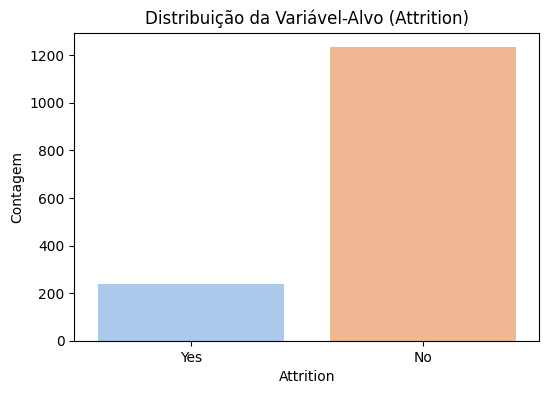

In [93]:
# 1. Análise da Distribuição da Variável-Alvo (Attrition)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Attrition', palette='pastel')
plt.title('Distribuição da Variável-Alvo (Attrition)')
plt.xlabel('Attrition')
plt.ylabel('Contagem')
plt.show()

> Distribuição da variável-alvo ("Attrition"):

> A classe "No" é significativamente mais frequente do que "Yes", indicando um desbalanceamento nas classes.


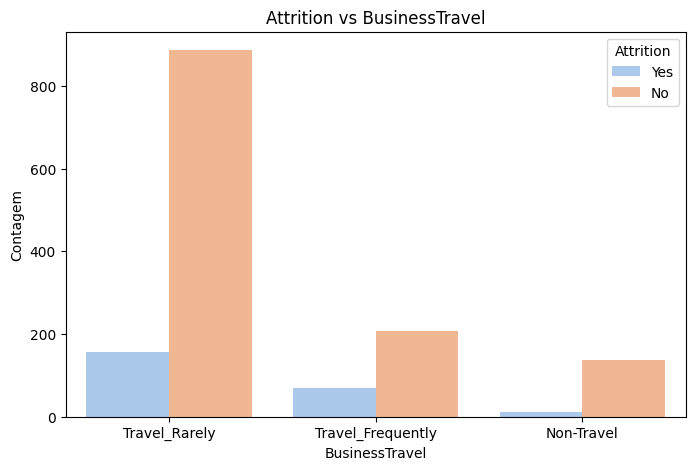

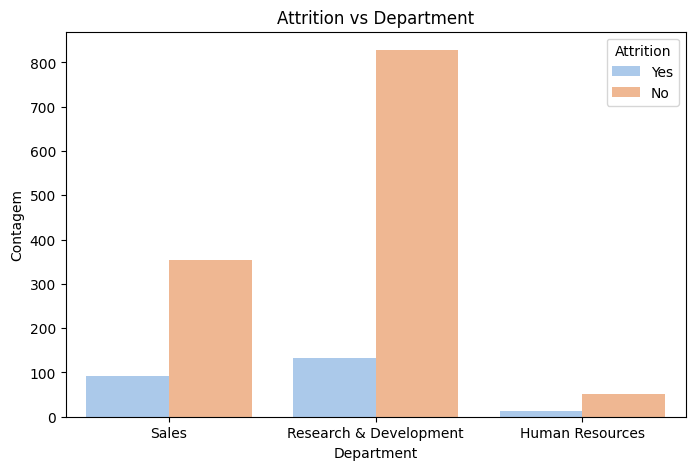

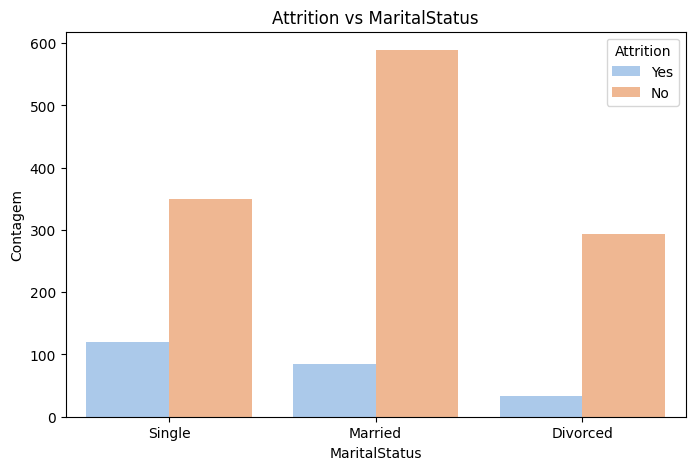

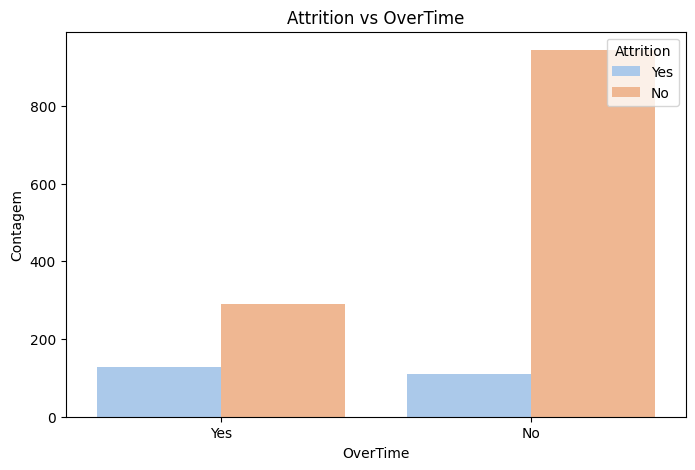

In [94]:
# 2. Relação entre "Attrition" e algumas variáveis categóricas
categorical_features = ['BusinessTravel', 'Department', 'MaritalStatus', 'OverTime']
for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=feature, hue='Attrition', palette='pastel')
    plt.title(f'Attrition vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Contagem')
    plt.legend(title='Attrition', loc='upper right')
    plt.show()

> Relação entre "Attrition" e variáveis categóricas:

> Funcionários que viajam frequentemente ("Travel_Frequently") ou muito raramente ("Travel_Rarely") apresentam diferenças no padrão de "Attrition".

> Departamentos e status marital também mostram padrões específicos em relação à rotatividade.

> O "OverTime" tem uma correlação clara, com maior rotatividade em funcionários que fazem horas extras.


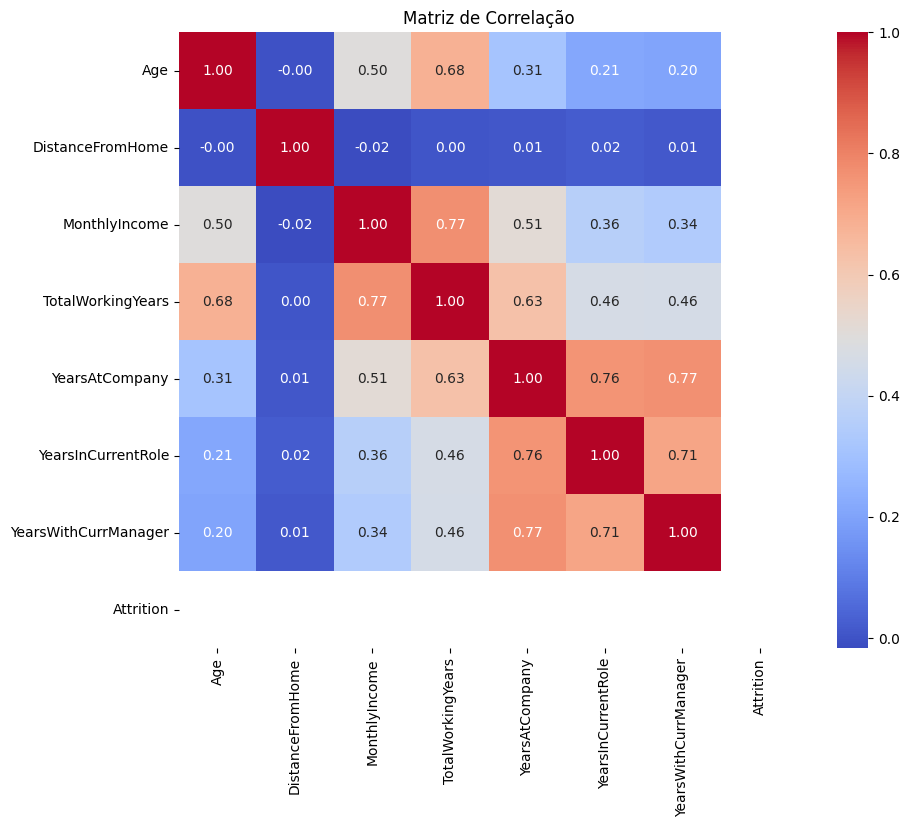

In [95]:
# 3. Análise de Correlação entre Variáveis Numéricas
numerical_features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears',
                      'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']

# Calcular correlação para variáveis numéricas
corr_matrix = data[numerical_features + ['Attrition']].apply(
    lambda col: pd.to_numeric(col, errors='coerce')).corr()

# Visualizar correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

> Matriz de correlação:

> Algumas variáveis contínuas como "TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsInCurrentManager" e "MonthlyIncome" apresentam uma correlação moderada entre sí.

> Vamos validar com o VIF para verificar se existe ou não colinearidade entre as variaveis.


<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


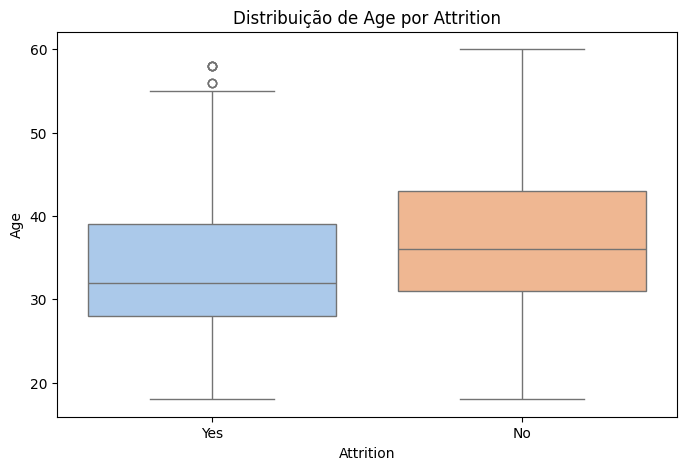

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


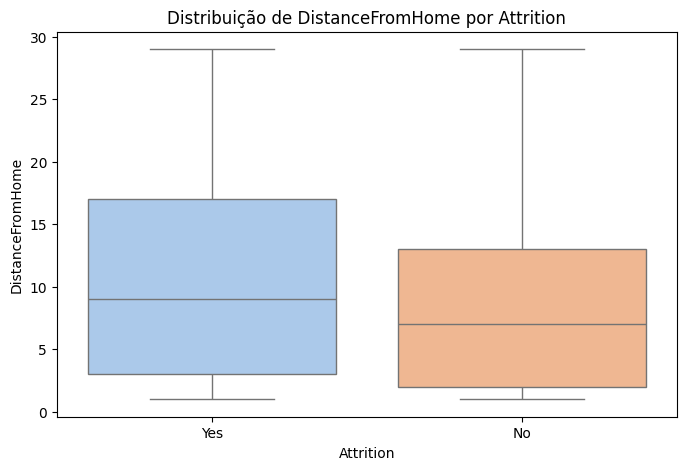

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


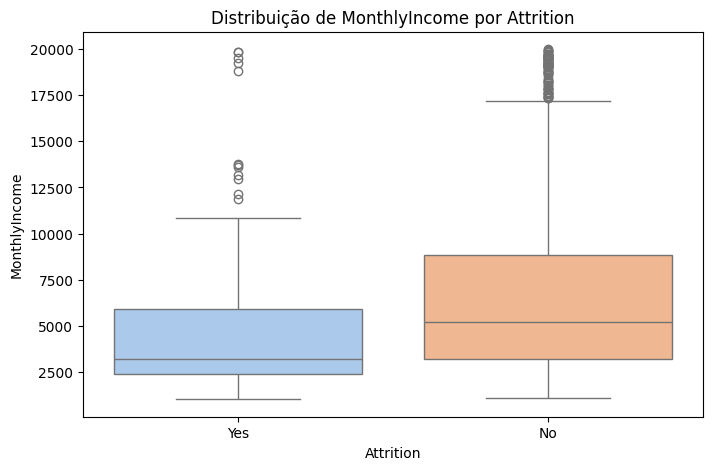

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


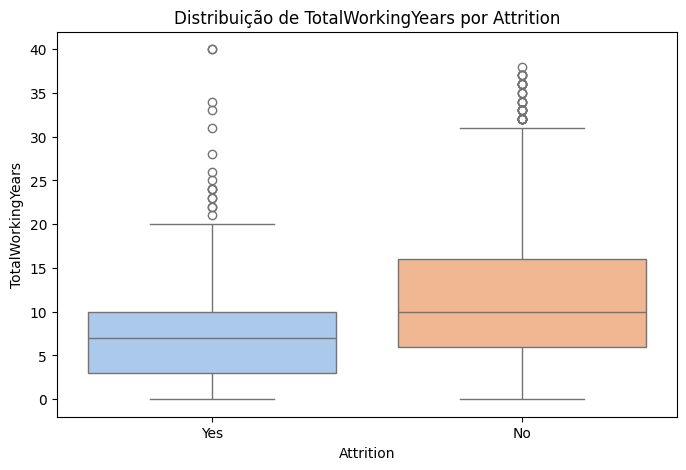

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


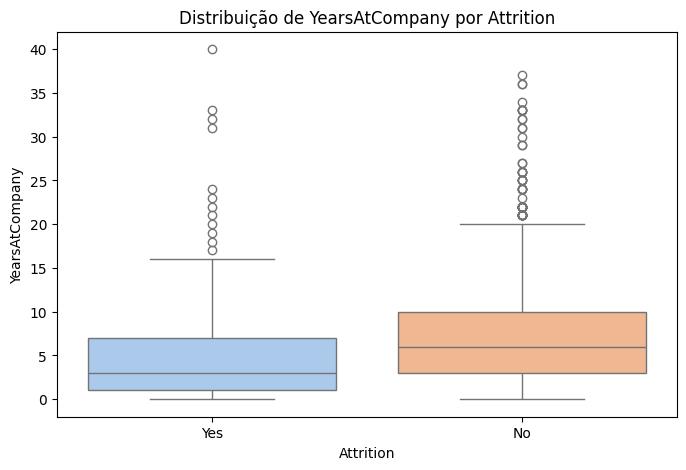

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


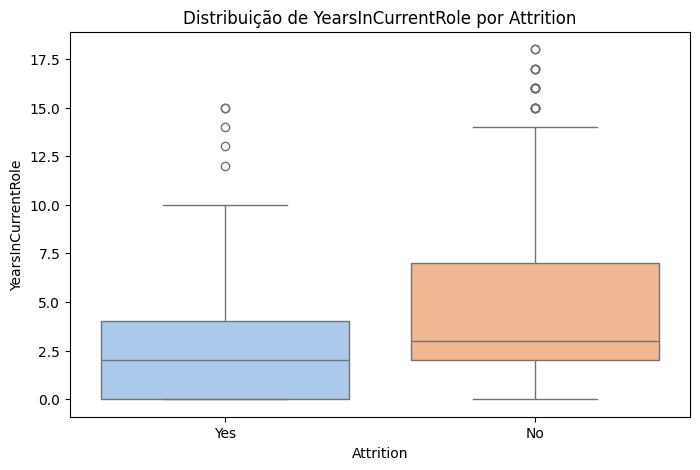

<ipython-input-96-42cd40c4c96d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')


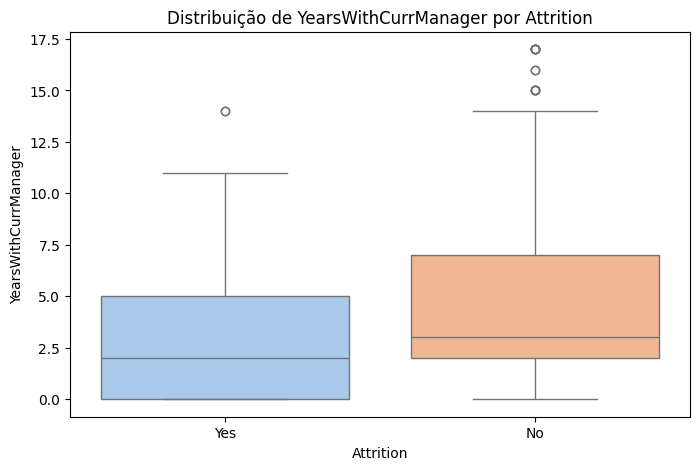

In [96]:
# 4. Distribuição de variáveis contínuas agrupadas por "Attrition"
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='Attrition', y=feature, palette='pastel')
    plt.title(f'Distribuição de {feature} por Attrition')
    plt.xlabel('Attrition')
    plt.ylabel(feature)
    plt.show()

> Distribuição de variáveis contínuas agrupadas por "Attrition":

> Há diferenças nas distribuições de "Age", "MonthlyIncome", e "YearsAtCompany" entre funcionários que permanecem e os que saem.

# Testes estatisticos

In [97]:
# Separando os dados com base na variável Attrition
group_0 = data[data['Attrition'] == 'No']
group_1 = data[data['Attrition'] == 'Yes']

# Teste t para diferenças significativas nas variáveis contínuas
t_test_results = {}
for feature in numerical_features:
    t_stat, p_value = ttest_ind(group_0[feature], group_1[feature], equal_var=False)
    t_test_results[feature] = {'t_stat': t_stat, 'p_value': p_value}

# Convertendo resultados do teste t para DataFrame
t_test_df = pd.DataFrame(t_test_results).T
t_test_df['Significance'] = t_test_df['p_value'] < 0.05  # Marcando significância
t_test_df.reset_index(inplace=True)
t_test_df.rename(columns={'index': 'Feature'}, inplace=True)

# Exibindo os resultados do Teste t
print("Resultados do Teste t para Diferenças de Médias entre Grupos:")
print(t_test_df)

Resultados do Teste t para Diferenças de Médias entre Grupos:
                Feature    t_stat       p_value  Significance
0                   Age  5.828012  1.379760e-08          True
1      DistanceFromHome -2.888183  4.136512e-03          True
2         MonthlyIncome  7.482622  4.433589e-13          True
3     TotalWorkingYears  7.019179  1.159817e-11          True
4        YearsAtCompany  5.282596  2.285905e-07          True
5    YearsInCurrentRole  6.847079  3.187390e-11          True
6  YearsWithCurrManager  6.633399  1.185022e-10          True


> Significância estatística: Todas as variáveis analisadas apresentaram diferenças significativas entre os grupos de Attrition ("Yes" e "No"), com p-valores muito baixos (<0.05). Isso sugere que essas variáveis podem ser úteis para prever a rotatividade.

> Variáveis com maior impacto: MonthlyIncome, TotalWorkingYears, e YearsInCurrentRole possuem os maiores valores de t, indicando fortes diferenças médias entre os grupos.

> Implicação para o modelo: Essas variáveis devem ser priorizadas no modelo, pois têm alto potencial preditivo para a rotatividade.

In [99]:
# Calculando o VIF
X = data[numerical_features].apply(pd.to_numeric, errors='coerce')
X['Intercept'] = 1  # Adicionando constante

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Removendo constante da análise de VIF
vif_data = vif_data[vif_data['Feature'] != 'Intercept']
vif_data.reset_index(drop=True, inplace=True)

# Exibindo os resultados do VIF
print("\nResultados do VIF (Fator de Inflação da Variância):")
print(vif_data)


Resultados do VIF (Fator de Inflação da Variância):
                Feature       VIF
0                   Age  1.951211
1      DistanceFromHome  1.001511
2         MonthlyIncome  2.519493
3     TotalWorkingYears  4.418899
4        YearsAtCompany  3.987455
5    YearsInCurrentRole  2.616693
6  YearsWithCurrManager  2.741566


> Baixa colinearidade: Todos os valores de VIF estão abaixo de 5, indicando que as variáveis analisadas não possuem problemas significativos de multicolinearidade.

> Variável com maior VIF: TotalWorkingYears apresenta o maior VIF (4.42), mas ainda está dentro de um limite aceitável.

> Implicação para o modelo: Não há necessidade de remover ou combinar variáveis devido à colinearidade. O modelo deve ser capaz de lidar bem com os dados.



# Seleção de Variáveis

In [100]:
# Lista final de variáveis contínuas selecionadas com base no Teste t
selected_numerical_features = [
    'Age', 'DistanceFromHome', 'MonthlyIncome',
    'TotalWorkingYears', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

# Variáveis categóricas identificadas como relevantes na EDA
selected_categorical_features = [
    'BusinessTravel', 'Department', 'MaritalStatus', 'OverTime'
]

# Criando o DataFrame final com variáveis categóricas codificadas e contínuas
# Codificando variáveis categóricas usando one-hot encoding
categorical_encoded = pd.get_dummies(data[selected_categorical_features], drop_first=True)

# Concatenando variáveis contínuas e categóricas
X_selected = pd.concat([data[selected_numerical_features], categorical_encoded], axis=1)

# Variável dependente (target)
y = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Transformando para binário

# Exibindo as primeiras linhas do DataFrame final
X_selected.head(), y.head()


(   Age  DistanceFromHome  MonthlyIncome  TotalWorkingYears  YearsAtCompany  \
 0   41                 1           5993                  8               6   
 1   49                 8           5130                 10              10   
 2   37                 2           2090                  7               0   
 3   33                 3           2909                  8               8   
 4   27                 2           3468                  6               2   
 
    YearsInCurrentRole  YearsWithCurrManager  BusinessTravel_Travel_Frequently  \
 0                   4                     5                             False   
 1                   7                     7                              True   
 2                   0                     0                             False   
 3                   7                     0                              True   
 4                   2                     2                             False   
 
    BusinessTravel_Travel_Rare

> O DataFrame final contém as variáveis selecionadas (X_selected) e a variável dependente binária (y).

# Construção do Modelo


In [101]:
# Divisão dos dados em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=4, stratify=y)

# Treinando o modelo de regressão logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Métricas de Desempenho:
Acurácia: 0.86
Precisão: 0.77
Recall: 0.21
F1-Score: 0.33

Matriz de Confusão:
[[244   3]
 [ 37  10]]


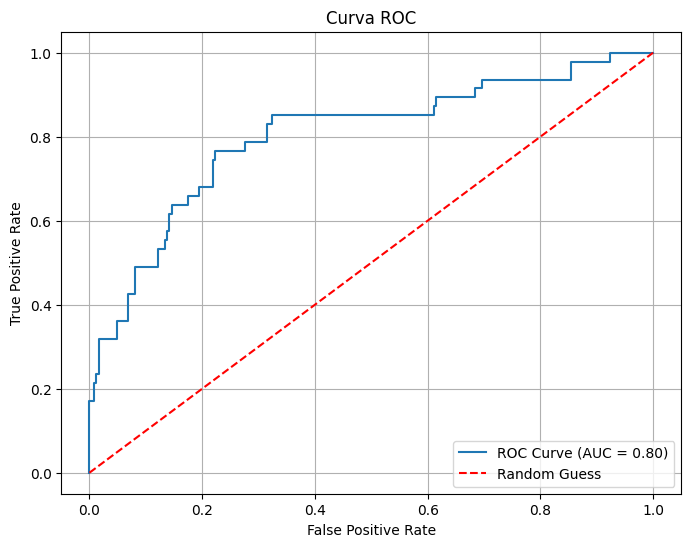

In [102]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibindo métricas de desempenho
print("Métricas de Desempenho:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(conf_matrix)

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

> Força: O modelo apresenta boa precisão e AUC.

>Fraqueza: O baixo recall e F1-Score mostram que o modelo não está lidando bem com a classe minoritária.

## Melhorando o modelo

In [103]:
# Passo 1: Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Passo 2: Treinar o modelo com os dados balanceados
log_model_balanced = LogisticRegression(max_iter=1000, random_state=42)
log_model_balanced.fit(X_train_balanced, y_train_balanced)

# Passo 3: Fazer previsões no conjunto de teste com ajuste de threshold
y_pred_prob_balanced = log_model_balanced.predict_proba(X_test)[:, 1]

# Ajustar o threshold para melhorar o recall (exemplo: 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_prob_balanced >= threshold).astype(int)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

Métricas de Desempenho com Dados Balanceados e Threshold Ajustado:
Acurácia: 0.56
Precisão: 0.23
Recall: 0.74
F1-Score: 0.35

Matriz de Confusão com Dados Balanceados e Threshold Ajustado:
[[130 117]
 [ 12  35]]


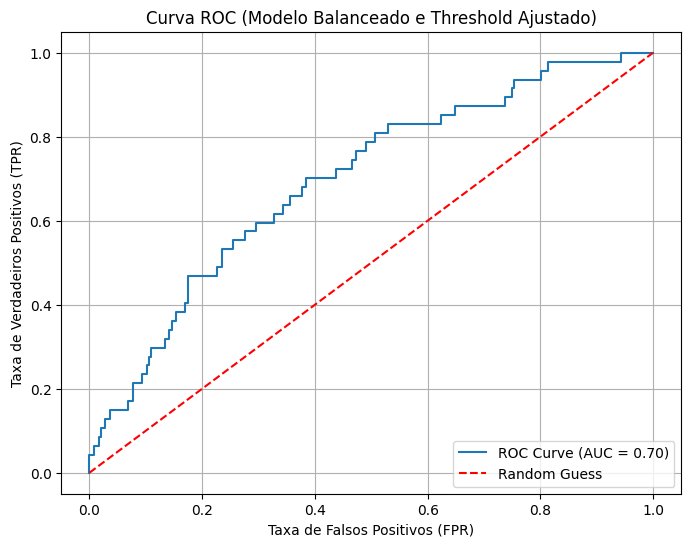

In [104]:
# Avaliar o modelo ajustado
accuracy_balanced = accuracy_score(y_test, y_pred_adjusted)
precision_balanced = precision_score(y_test, y_pred_adjusted)
recall_balanced = recall_score(y_test, y_pred_adjusted)
f1_balanced = f1_score(y_test, y_pred_adjusted)

# Exibir as métricas do modelo ajustado
print("Métricas de Desempenho com Dados Balanceados e Threshold Ajustado:")
print(f"Acurácia: {accuracy_balanced:.2f}")
print(f"Precisão: {precision_balanced:.2f}")
print(f"Recall: {recall_balanced:.2f}")
print(f"F1-Score: {f1_balanced:.2f}")

# Matriz de confusão
conf_matrix_balanced = confusion_matrix(y_test, y_pred_adjusted)
print("\nMatriz de Confusão com Dados Balanceados e Threshold Ajustado:")
print(conf_matrix_balanced)

# Curva ROC para o modelo ajustado
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_pred_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'ROC Curve (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title('Curva ROC (Modelo Balanceado e Threshold Ajustado)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Após aplicar o SMOTE para balancear as classes e ajustar o threshold para priorizar o recall, o modelo apresentou as seguintes melhorias:

> Recall: Melhorou significativamente de 0.21 para 0.74, indicando que o modelo agora consegue identificar a maioria dos casos reais de Attrition = Yes.

> F1-Score: Aumentou de 0.33 para 0.35, refletindo uma melhor combinação de recall e precisão.

> Precisão: Reduziu de 0.77 para 0.23, devido ao aumento de falsos positivos ao priorizar recall.

> Acurácia: Caiu de 0.86 para 0.56, mas isso era esperado, já que o foco foi melhorar a identificação da classe minoritária.

Matriz de Confusão:

> Verdadeiros Positivos (35): Casos de Attrition = Yes identificados corretamente.

> Falsos Negativos (12): Redução significativa em relação ao modelo inicial.

> Falsos Positivos (117): Aumento esperado ao priorizar recall.

> Verdadeiros Negativos (130): Casos de Attrition = No identificados corretamente.

Conclusão: O modelo agora é mais eficaz para o objetivo de identificar funcionários propensos à saída (alto recall), mas com a compensação de menor precisão e acurácia geral.

# Interpretação e Resultados

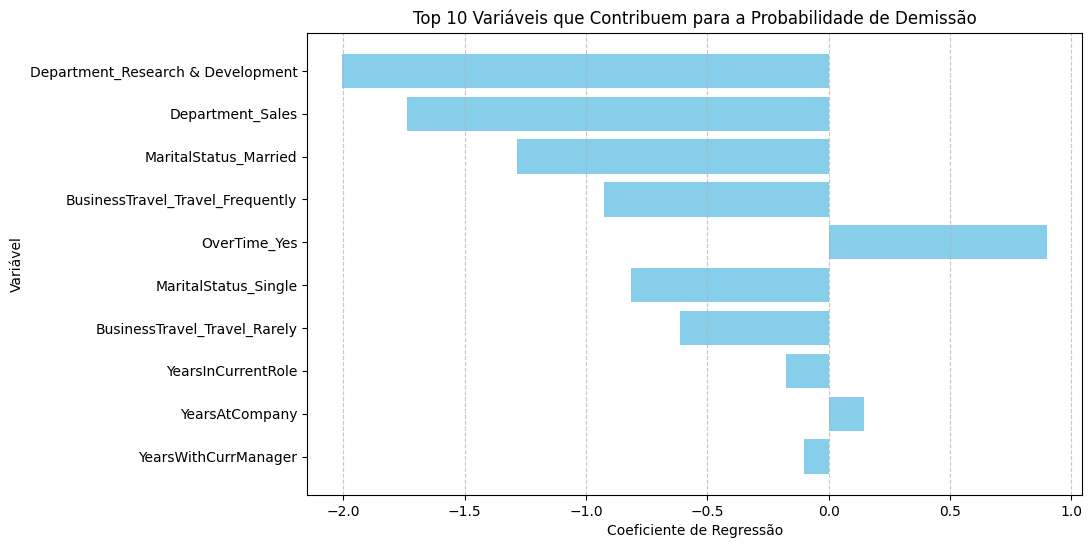

In [105]:

# Coeficientes de Regressão
coefficients = log_model_balanced.coef_[0]
features = X_selected.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Ordenando as variáveis pela magnitude do coeficiente (impacto no modelo)
coef_df['Absolute_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Exibindo os 10 principais contribuintes
top_features = coef_df.head(10)

# Visualização dos coeficientes
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.title('Top 10 Variáveis que Contribuem para a Probabilidade de Demissão')
plt.xlabel('Coeficiente de Regressão')
plt.ylabel('Variável')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Interpretação das probabilidades preditivas
# Exemplo: Predizendo a probabilidade para os primeiros 5 funcionários no conjunto de teste
example_probs = log_model_balanced.predict_proba(X_test[:5])[:, 1]
example_preds = log_model_balanced.predict(X_test[:5])
example_results = pd.DataFrame({
    'Employee_ID': X_test.index[:5],
    'Predicted_Probability': example_probs,
    'Predicted_Class': example_preds
})

> Conclusão: Variáveis relacionadas a condições de trabalho (horas extras, tempo de permanência em um papel) e características demográficas (estado civil, departamento) têm papéis importantes na probabilidade de saída.

In [106]:
# Exibindo os resultados das probabilidades preditivas para os exemplos
example_results.reset_index(drop=True, inplace=True)
print("Exemplo de Probabilidades Preditivas para Funcionários:")
print(example_results)


Exemplo de Probabilidades Preditivas para Funcionários:
   Employee_ID  Predicted_Probability  Predicted_Class
0           35               0.427293                0
1         1082               0.482550                0
2          513               0.717455                1
3         1047               0.202950                0
4          686               0.088839                0


# Validação

In [107]:

# Validação Cruzada (5-fold) para verificar a robustez do modelo
cv_scores = cross_val_score(log_model_balanced, X_selected, y, cv=5, scoring='f1')

# Exibindo a média e o desvio padrão das F1-Scores da validação cruzada
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [108]:
print("Validação Cruzada (5-fold):")
print(f"F1-Score Médio: {mean_cv_score:.2f}")
print(f"Desvio Padrão do F1-Score: {std_cv_score:.2f}")

Validação Cruzada (5-fold):
F1-Score Médio: 0.32
Desvio Padrão do F1-Score: 0.03


Validação Cruzada (5-fold):

> F1-Score Médio (0.32): O desempenho médio do modelo em diferentes divisões dos dados indica que ele tem dificuldade em equilibrar precisão e recall. Isso é consistente com os desafios de prever a classe minoritária (Attrition = Yes).

> Desvio Padrão (0.03): O modelo é relativamente estável, pois a variação do F1-Score entre os folds é baixa.
Interpretação:

O modelo apresenta resultados consistentes, mas o desempenho médio ainda está limitado, sugerindo que há espaço para melhorias (e.g., ajuste de parâmetros ou uso de modelos mais avançados).

In [109]:
# Avaliação com dados não utilizados no treinamento (se disponíveis)
# Como o conjunto de teste já é separado, vamos utilizá-lo como proxy para validação externa
y_pred_test = log_model_balanced.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print("\nAvaliação no Conjunto de Teste:")
print(f"Acurácia no Teste: {test_accuracy:.2f}")
print(f"F1-Score no Teste: {test_f1:.2f}")



Avaliação no Conjunto de Teste:
Acurácia no Teste: 0.73
F1-Score no Teste: 0.36


Avaliação no Conjunto de Teste:

> Acurácia (0.73): O modelo acerta 73% das previsões no conjunto de teste. Isso é aceitável, mas a acurácia pode ser enganosa em conjuntos desbalanceados.

> F1-Score (0.36): O equilíbrio entre precisão e recall no conjunto de teste é moderado, com desempenho um pouco melhor do que na validação cruzada.
Interpretação:

O F1-Score mais alto no conjunto de teste em relação à validação cruzada sugere que o modelo conseguiu generalizar melhor nos dados de teste, mas o valor absoluto ainda é limitado para aplicações práticas.

# Conclusão

O modelo atual forneceu bons insights iniciais, mas ainda há espaço para melhorias significativas na performance preditiva. Focar em modelos mais avançados, melhor balanceamento de classes e engenharia de features pode levar a resultados mais robustos e acionáveis para o problema de retenção de funcionários.